## Семинар 6 "Segmentation"

ФИО: __Быстров Иван Дмитриевич__

Ivan_Bystrov_sphere

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 ноября 2021). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

import torch
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms as tsf
import scipy.misc
import torch.nn as nn
from pathlib import Path

from PIL import Image
import skimage
from skimage import io
from IPython.display import clear_output

from torch.utils.tensorboard import SummaryWriter

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [3]:
SIZE1 = 565
SIZE2 = 584
dev = "cuda"

In [4]:
pip install imagecodecs

In [5]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = torch.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = torch.from_numpy(mask)
        data.append(item)
    
    return data
test = process('/content/drive/MyDrive/test/images/')
torch.save(test, TEST_PATH)
train_data = process('/content/drive/MyDrive/train/images', "/content/drive/MyDrive/train/1st_manual/")

In [6]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((SIZE1, SIZE2)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((SIZE1, SIZE2),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=4, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [7]:
class my_Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        return data[0], data[1]
    def __len__(self):
        return len(self.datas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


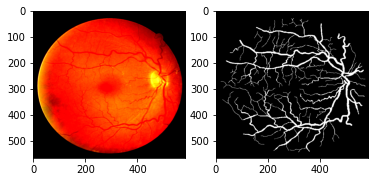

In [8]:
img,mask = dataset[1]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*1.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy(), cmap='gray')

In [9]:
angles = [i*7.5 for i in range(1,48)]

In [10]:
angles

[7.5,
 15.0,
 22.5,
 30.0,
 37.5,
 45.0,
 52.5,
 60.0,
 67.5,
 75.0,
 82.5,
 90.0,
 97.5,
 105.0,
 112.5,
 120.0,
 127.5,
 135.0,
 142.5,
 150.0,
 157.5,
 165.0,
 172.5,
 180.0,
 187.5,
 195.0,
 202.5,
 210.0,
 217.5,
 225.0,
 232.5,
 240.0,
 247.5,
 255.0,
 262.5,
 270.0,
 277.5,
 285.0,
 292.5,
 300.0,
 307.5,
 315.0,
 322.5,
 330.0,
 337.5,
 345.0,
 352.5]

In [11]:
datt = []
for data in dataset:
    datt.append(data)
    img, mask = data
    angles = [i*15 for i in range(1,48)]
    for ang in angles:
        datt.append((tsf.functional.rotate(img, ang), tsf.functional.rotate(mask, ang)))
    datt.append((tsf.functional.vflip(img), tsf.functional.vflip(mask)))
    datt.append((tsf.functional.hflip(img), tsf.functional.hflip(mask)))

In [12]:
batch_sz = 6

In [13]:
dataset1 = my_Dataset(datt,s_trans,t_trans)
dataloader1 = torch.utils.data.DataLoader(dataset1, batch_size=batch_sz, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


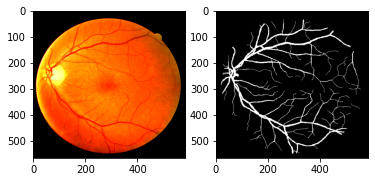

In [14]:
img,mask = dataset1[0]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*1.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy(), cmap='gray')

In [15]:
len(dataset1)

1000

In [16]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch) 

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = torch.sigmoid(x)
        return x

In [17]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [18]:
model = UNet(3,1)# Your model here

In [19]:
def train(network, train_loader, epochs, 
          learning_rate, batch_size, device="cpu", hlp=0):
    loss = soft_dice_loss
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            losses = []
            for X, y in tqdm(train_loader):
                X = X.to(device)
                y = y.to(device)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.cpu().item())
                loss_batch.backward()
                optimizer.step()
            train_loss_epochs.append(np.mean(losses))
            clear_output(True)
            sys.stdout.write('\rEpoch {0}... (Train) LOSS: {1:.3f}'.format(
                            epoch, train_loss_epochs[-1]))
            plot = True
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
            path = "/content/drive/MyDrive/train/fs-eyes-{}.tar".format(epoch+1+hlp)
            torch.save(network.state_dict(), path)
    except KeyboardInterrupt:
        pass
    return train_loss_epochs

In [20]:
dev = "cuda"

Epoch 14... (Train) LOSS: 0.180

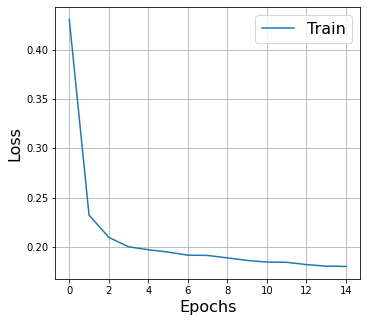

  2%|▏         | 3/167 [00:15<14:12,  5.20s/it]


[0.4306648948235426,
 0.23226303326155612,
 0.20964978019634406,
 0.2001270830274342,
 0.19717462691004406,
 0.1947553796682529,
 0.19166856183263356,
 0.19137819155961452,
 0.1888875811399814,
 0.18632457463327282,
 0.1846399881882582,
 0.1844156502249712,
 0.18206433264795177,
 0.1805296900743496,
 0.1802125862258637]

In [21]:
train(model, dataloader1, 40, 0.001, batch_sz, dev)

In [21]:
path1 = "/content/drive/MyDrive/train/fs-eyes-15.tar"

In [22]:
model.load_state_dict(torch.load(path1))

<All keys matched successfully>

Epoch 4... (Train) LOSS: 0.175

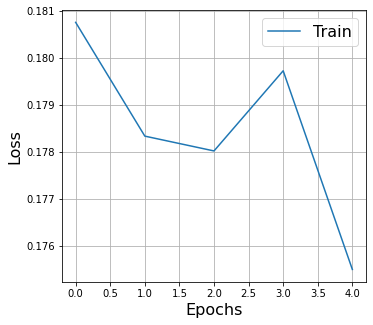

[0.18075868005524137,
 0.1783336111885345,
 0.17801785397672368,
 0.17972646430580916,
 0.17549196046269583]

In [23]:
train(model, dataloader1, 5, 0.001, batch_sz, dev, 14)

In [21]:
path2 = "/content/drive/MyDrive/train/fs-eyes-10.tar"

In [22]:
model.load_state_dict(torch.load(path2))

<All keys matched successfully>

In [23]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = torch.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
test_dataloader = torch.utils.data.DataLoader(testset,batch_size=1)

In [24]:
from skimage import transform
import imageio

In [26]:
model1 = model.eval()
for ex_id, data in enumerate(test_dataloader):
    if dev == "cuda":
        data = torch.autograd.Variable(data, volatile=True).cuda()
    else:
        data = torch.autograd.Variable(data, volatile=True).cpu()
    o = model1(data.cpu())
    print('!')
    source_image = io.imread("drive/MyDrive/test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("drive/MyDrive/test/result/%s.png" % (ex_id + 1), tm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


!


!


!


!


!


!


!


!


!


!


!


!


!


!


!


!


!


!


!


!


Пробовал увеличивать датасет за счет вращений + постепенно наращивал разрешение (вплоть до исходного). Также варьировал размеры батча (версия с батчом размера 1 и разрешением 250 оказалась крайне неудачной - score 0.06 на картинке 2). Пробовал разное число эпох обучения - при кол-ве >= 90 модель начинает переобучаться. В будущем попробую добавить шум в изображения, при этом постараюсь уменьшить размер датасета и разрешение картинок - модель очень долго учится, регулярно прилетают баны на google collab - пришлось регулярно сейвить модели  и учить на дополнительных аккаунтах (видимо, надо учиться пользоваться учебным сервером)

Upd: расширение датасета до 1000 изображений значительно увеличило время обучения на одну эпоху, и в то же время позволило получить значительно более высокий скор за меньшее число эпох. Максимальный скор (0.8176) был достигнут на 10-й эпохе